## Improvise a Jazz Solo with an LSTM Network - Andrew Ng

In [1]:
import IPython
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from itertools import groupby, zip_longest
from music21 import *
import tensorflow as tf

from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [31]:
# code only work with this version
# _parse_midi() : melody1, melody2 = melody_stream.getElementsByClass(stream.Voice) -> error can't unpack for later version
import music21
music21.__version__

'6.7.1'

## Problem Statement
You would like to create a jazz music piece specially for a friend's birthday. However, you don't know how to play any instruments, or how to compose music. Fortunately, you know deep learning and will solve this problem using an LSTM network!

You will train a network to generate novel jazz solos in a style representative of a body of performed work. 😎🎷

### Dataset
To get started, you'll train your algorithm on a corpus of Jazz music. Run the cell below to listen to a snippet of the audio from the training set:

In [2]:
IPython.display.Audio('30s_seq.mp3')

The preprocessing of the musical data has been taken care of already, which for this notebook means it's been rendered in terms of musical "values."

What are musical "values"?

You can informally think of each "value" as a note, which comprises a pitch and duration. For example, if you press down a specific piano key for 0.5 seconds, then you have just played a note. In music theory, a "value" is actually more complicated than this -- specifically, it also captures the information needed to play multiple notes at the same time. For example, when playing a music piece, you might press down two piano keys at the same time (playing multiple notes at the same time generates what's called a "chord"). But you don't need to worry about the details of music theory for this assignment.

Music as a sequence of values
* For the purposes of this assignment, all you need to know is that you'll obtain a dataset of values, and will use an RNN model to generate sequences of values.
* Your music generation system will use 90 unique values.

In [29]:
def __is_scale_tone(chord, note):
    # Method: generate all scales that have the chord notes th check if note is
    # in names

    # Derive major or minor scales (minor if 'other') based on the quality
    # of the chord.
    scaleType = scale.DorianScale() # i.e. minor pentatonic
    if chord.quality == 'major':
        scaleType = scale.MajorScale()
    # Can change later to deriveAll() for flexibility. If so then use list
    # comprehension of form [x for a in b for x in a].
    scales = scaleType.derive(chord) # use deriveAll() later for flexibility
    allPitches = list(set([pitch for pitch in scales.getPitches()]))
    allNoteNames = [i.name for i in allPitches] # octaves don't matter

    # Get note name. Return true if in the list of note names.
    noteName = note.name
    return (noteName in allNoteNames)

''' Helper function to determine if a note is an approach tone. '''
def __is_approach_tone(chord, note):
    # Method: see if note is +/- 1 a chord tone.

    for chordPitch in chord.pitches:
        stepUp = chordPitch.transpose(1)
        stepDown = chordPitch.transpose(-1)
        if (note.name == stepDown.name or 
            note.name == stepDown.getEnharmonic().name or
            note.name == stepUp.name or
            note.name == stepUp.getEnharmonic().name):
                return True
    return False

''' Helper function to determine if a note is a chord tone. '''
def __is_chord_tone(lastChord, note):
    return (note.name in (p.name for p in lastChord.pitches))

''' Helper function to generate a chord tone. '''
def __generate_chord_tone(lastChord):
    lastChordNoteNames = [p.nameWithOctave for p in lastChord.pitches]
    return note.Note(random.choice(lastChordNoteNames))

''' Helper function to generate a scale tone. '''
def __generate_scale_tone(lastChord):
    # Derive major or minor scales (minor if 'other') based on the quality
    # of the lastChord.
    scaleType = scale.WeightedHexatonicBlues() # minor pentatonic
    if lastChord.quality == 'major':
        scaleType = scale.MajorScale()
    # Can change later to deriveAll() for flexibility. If so then use list
    # comprehension of form [x for a in b for x in a].
    scales = scaleType.derive(lastChord) # use deriveAll() later for flexibility
    allPitches = list(set([pitch for pitch in scales.getPitches()]))
    allNoteNames = [i.name for i in allPitches] # octaves don't matter

    # Return a note (no octave here) in a scale that matches the lastChord.
    sNoteName = random.choice(allNoteNames)
    lastChordSort = lastChord.sortAscending()
    sNoteOctave = random.choice([i.octave for i in lastChordSort.pitches])
    sNote = note.Note(("%s%s" % (sNoteName, sNoteOctave)))
    return sNote

''' Helper function to generate an approach tone. '''
def __generate_approach_tone(lastChord):
    sNote = __generate_scale_tone(lastChord)
    aNote = sNote.transpose(random.choice([1, -1]))
    return aNote

''' Helper function to generate a random tone. '''
def __generate_arbitrary_tone(lastChord):
    return __generate_scale_tone(lastChord) # fix later, make random note.


''' Given the notes in a measure ('measure') and the chords in that measure
    ('chords'), generate a list of abstract grammatical symbols to represent 
    that measure as described in GTK's "Learning Jazz Grammars" (2009). 

    Inputs: 
    1) "measure" : a stream.Voice object where each element is a
        note.Note or note.Rest object.

        >>> m1
        <music21.stream.Voice 328482572>
        >>> m1[0]
        <music21.note.Rest rest>
        >>> m1[1]
        <music21.note.Note C>

        Can have instruments and other elements, removes them here.

    2) "chords" : a stream.Voice object where each element is a chord.Chord.

        >>> c1
        <music21.stream.Voice 328497548>
        >>> c1[0]
        <music21.chord.Chord E-4 G4 C4 B-3 G#2>
        >>> c1[1]
        <music21.chord.Chord B-3 F4 D4 A3>

        Can have instruments and other elements, removes them here. 

    Outputs:
    1) "fullGrammar" : a string that holds the abstract grammar for measure.
        Format: 
        (Remember, these are DURATIONS not offsets!)
        "R,0.125" : a rest element of  (1/32) length, or 1/8 quarter note. 
        "C,0.125<M-2,m-6>" : chord note of (1/32) length, generated
                             anywhere from minor 6th down to major 2nd down.
                             (interval <a,b> is not ordered). '''

def parse_melody(fullMeasureNotes, fullMeasureChords):
    # Remove extraneous elements.x
    measure = copy.deepcopy(fullMeasureNotes)
    chords = copy.deepcopy(fullMeasureChords)
    measure.removeByNotOfClass([note.Note, note.Rest])
    chords.removeByNotOfClass([chord.Chord])

    # Information for the start of the measure.
    # 1) measureStartTime: the offset for measure's start, e.g. 476.0.
    # 2) measureStartOffset: how long from the measure start to the first element.
    measureStartTime = measure[0].offset - (measure[0].offset % 4)
    measureStartOffset  = measure[0].offset - measureStartTime

    # Iterate over the notes and rests in measure, finding the grammar for each
    # note in the measure and adding an abstract grammatical string for it. 

    fullGrammar = ""
    prevNote = None # Store previous note. Need for interval.
    numNonRests = 0 # Number of non-rest elements. Need for updating prevNote.
    for ix, nr in enumerate(measure):
        # Get the last chord. If no last chord, then (assuming chords is of length
        # >0) shift first chord in chords to the beginning of the measure.
        try: 
            lastChord = [n for n in chords if n.offset <= nr.offset][-1]
        except IndexError:
            chords[0].offset = measureStartTime
            lastChord = [n for n in chords if n.offset <= nr.offset][-1]

        # FIRST, get type of note, e.g. R for Rest, C for Chord, etc.
        # Dealing with solo notes here. If unexpected chord: still call 'C'.
        elementType = ' '
        # R: First, check if it's a rest. Clearly a rest --> only one possibility.
        if isinstance(nr, note.Rest):
            elementType = 'R'
        # C: Next, check to see if note pitch is in the last chord.
        elif nr.name in lastChord.pitchNames or isinstance(nr, chord.Chord):
            elementType = 'C'
        # L: (Complement tone) Skip this for now.
        # S: Check if it's a scale tone.
        elif __is_scale_tone(lastChord, nr):
            elementType = 'S'
        # A: Check if it's an approach tone, i.e. +-1 halfstep chord tone.
        elif __is_approach_tone(lastChord, nr):
            elementType = 'A'
        # X: Otherwise, it's an arbitrary tone. Generate random note.
        else:
            elementType = 'X'

        # SECOND, get the length for each element. e.g. 8th note = R8, but
        # to simplify things you'll use the direct num, e.g. R,0.125
        if (ix == (len(measure)-1)):
            # formula for a in "a - b": start of measure (e.g. 476) + 4
            diff = measureStartTime + 4.0 - nr.offset
        else:
            diff = measure[ix + 1].offset - nr.offset

        # Combine into the note info.
        noteInfo = "%s,%.3f" % (elementType, nr.quarterLength) # back to diff

        # THIRD, get the deltas (max range up, max range down) based on where
        # the previous note was, +- minor 3. Skip rests (don't affect deltas).
        intervalInfo = ""
        if isinstance(nr, note.Note):
            numNonRests += 1
            if numNonRests == 1:
                prevNote = nr
            else:
                noteDist = interval.Interval(noteStart=prevNote, noteEnd=nr)
                noteDistUpper = interval.add([noteDist, "m3"])
                noteDistLower = interval.subtract([noteDist, "m3"])
                intervalInfo = ",<%s,%s>" % (noteDistUpper.directedName, 
                    noteDistLower.directedName)
                # print "Upper, lower: %s, %s" % (noteDistUpper,
                #     noteDistLower)
                # print "Upper, lower dnames: %s, %s" % (
                #     noteDistUpper.directedName,
                #     noteDistLower.directedName)
                # print "The interval: %s" % (intervalInfo)
                prevNote = nr

        # Return. Do lazy evaluation for real-time performance.
        grammarTerm = noteInfo + intervalInfo 
        fullGrammar += (grammarTerm + " ")

    return fullGrammar.rstrip()

''' Given a grammar string and chords for a measure, returns measure notes. '''
def unparse_grammar(m1_grammar, m1_chords):
    m1_elements = stream.Voice()
    currOffset = 0.0 # for recalculate last chord.
    prevElement = None
    for ix, grammarElement in enumerate(m1_grammar.split(' ')):
        terms = grammarElement.split(',')
        currOffset += float(terms[1]) # works just fine

        # Case 1: it's a rest. Just append
        if terms[0] == 'R':
            rNote = note.Rest(quarterLength = float(terms[1]))
            m1_elements.insert(currOffset, rNote)
            continue

        # Get the last chord first so you can find chord note, scale note, etc.
        try: 
            lastChord = [n for n in m1_chords if n.offset <= currOffset][-1]
        except IndexError:
            m1_chords[0].offset = 0.0
            lastChord = [n for n in m1_chords if n.offset <= currOffset][-1]

        # Case: no < > (should just be the first note) so generate from range
        # of lowest chord note to highest chord note (if not a chord note, else
        # just generate one of the actual chord notes). 

        # Case #1: if no < > to indicate next note range. Usually this lack of < >
        # is for the first note (no precedent), or for rests.
        if (len(terms) == 2): # Case 1: if no < >.
            insertNote = note.Note() # default is C

            # Case C: chord note.
            if terms[0] == 'C':
                insertNote = __generate_chord_tone(lastChord)

            # Case S: scale note.
            elif terms[0] == 'S':
                insertNote = __generate_scale_tone(lastChord)

            # Case A: approach note.
            # Handle both A and X notes here for now.
            else:
                insertNote = __generate_approach_tone(lastChord)

            # Update the stream of generated notes
            insertNote.quarterLength = float(terms[1])
            if insertNote.octave < 4:
                insertNote.octave = 4
            m1_elements.insert(currOffset, insertNote)
            prevElement = insertNote

        # Case #2: if < > for the increment. Usually for notes after the first one.
        else:
            # Get lower, upper intervals and notes.
            interval1 = interval.Interval(terms[2].replace("<",''))
            interval2 = interval.Interval(terms[3].replace(">",''))
            if interval1.cents > interval2.cents:
                upperInterval, lowerInterval = interval1, interval2
            else:
                upperInterval, lowerInterval = interval2, interval1
            lowPitch = interval.transposePitch(prevElement.pitch, lowerInterval)
            highPitch = interval.transposePitch(prevElement.pitch, upperInterval)
            numNotes = int(highPitch.ps - lowPitch.ps + 1) # for range(s, e)

            # Case C: chord note, must be within increment (terms[2]).
            # First, transpose note with lowerInterval to get note that is
            # the lower bound. Then iterate over, and find valid notes. Then
            # choose randomly from those.
            
            if terms[0] == 'C':
                relevantChordTones = []
                for i in range(0, numNotes):
                    currNote = note.Note(lowPitch.transpose(i).simplifyEnharmonic())
                    if __is_chord_tone(lastChord, currNote):
                        relevantChordTones.append(currNote)
                if len(relevantChordTones) > 1:
                    insertNote = random.choice([i for i in relevantChordTones
                        if i.nameWithOctave != prevElement.nameWithOctave])
                elif len(relevantChordTones) == 1:
                    insertNote = relevantChordTones[0]
                else: # if no choices, set to prev element +-1 whole step
                    insertNote = prevElement.transpose(random.choice([-2,2]))
                if insertNote.octave < 3:
                    insertNote.octave = 3
                insertNote.quarterLength = float(terms[1])
                m1_elements.insert(currOffset, insertNote)

            # Case S: scale note, must be within increment.
            elif terms[0] == 'S':
                relevantScaleTones = []
                for i in range(0, numNotes):
                    currNote = note.Note(lowPitch.transpose(i).simplifyEnharmonic())
                    if __is_scale_tone(lastChord, currNote):
                        relevantScaleTones.append(currNote)
                if len(relevantScaleTones) > 1:
                    insertNote = random.choice([i for i in relevantScaleTones
                        if i.nameWithOctave != prevElement.nameWithOctave])
                elif len(relevantScaleTones) == 1:
                    insertNote = relevantScaleTones[0]
                else: # if no choices, set to prev element +-1 whole step
                    insertNote = prevElement.transpose(random.choice([-2,2]))
                if insertNote.octave < 3:
                    insertNote.octave = 3
                insertNote.quarterLength = float(terms[1])
                m1_elements.insert(currOffset, insertNote)

            # Case A: approach tone, must be within increment.
            # For now: handle both A and X cases.
            else:
                relevantApproachTones = []
                for i in range(0, numNotes):
                    currNote = note.Note(lowPitch.transpose(i).simplifyEnharmonic())
                    if __is_approach_tone(lastChord, currNote):
                        relevantApproachTones.append(currNote)
                if len(relevantApproachTones) > 1:
                    insertNote = random.choice([i for i in relevantApproachTones
                        if i.nameWithOctave != prevElement.nameWithOctave])
                elif len(relevantApproachTones) == 1:
                    insertNote = relevantApproachTones[0]
                else: # if no choices, set to prev element +-1 whole step
                    insertNote = prevElement.transpose(random.choice([-2,2]))
                if insertNote.octave < 3:
                    insertNote.octave = 3
                insertNote.quarterLength = float(terms[1])
                m1_elements.insert(currOffset, insertNote)

            # update the previous element.
            prevElement = insertNote

    return m1_elements    

In [36]:
''' Helper function to parse a MIDI file into its measures and chords '''
def __parse_midi(data_fn):
    # Parse the MIDI data for separate melody and accompaniment parts.
    midi_data = converter.parse(data_fn)
    # Get melody part, compress into single voice.
    melody_stream = midi_data[5]    # For Metheny piece, Melody is Part #5
    melody1, melody2 = melody_stream.getElementsByClass(stream.Voice)
    for j in melody2:
        melody1.insert(j.offset, j)
    melody_voice = melody1

    for i in melody_voice:
        if i.quarterLength == 0.0:
            i.quarterLength = 0.25

    # Change key signature to adhere to comp_stream (1 sharp, mode = major).
    # Also add Electric Guitar. 
    melody_voice.insert(0, instrument.ElectricGuitar())
    melody_voice.insert(0, key.KeySignature(sharps=1))

    # The accompaniment parts. Take only the best subset of parts from
    # the original data. Maybe add more parts, hand-add valid instruments.
    # Should add least add a string part (for sparse solos).
    # Verified are good parts: 0, 1, 6, 7 '''
    partIndices = [0, 1, 6, 7]
    comp_stream = stream.Voice()
    comp_stream.append([j.flat for i, j in enumerate(midi_data) 
        if i in partIndices])

    # Full stream containing both the melody and the accompaniment. 
    # All parts are flattened. 
    full_stream = stream.Voice()
    for i in range(len(comp_stream)):
        full_stream.append(comp_stream[i])
    full_stream.append(melody_voice)

    # Extract solo stream, assuming you know the positions ..ByOffset(i, j).
    # Note that for different instruments (with stream.flat), you NEED to use
    # stream.Part(), not stream.Voice().
    # Accompanied solo is in range [478, 548)
    solo_stream = stream.Voice()
    for part in full_stream:
        curr_part = stream.Part()
        curr_part.append(part.getElementsByClass(instrument.Instrument))
        curr_part.append(part.getElementsByClass(tempo.MetronomeMark))
        curr_part.append(part.getElementsByClass(key.KeySignature))
        curr_part.append(part.getElementsByClass(meter.TimeSignature))
        curr_part.append(part.getElementsByOffset(476, 548, 
                                                  includeEndBoundary=True))
        cp = curr_part.flat
        solo_stream.insert(cp)

    # Group by measure so you can classify. 
    # Note that measure 0 is for the time signature, metronome, etc. which have
    # an offset of 0.0.
    melody_stream = solo_stream[-1]
    measures = OrderedDict()
    offsetTuples = [(int(n.offset / 4), n) for n in melody_stream]
    measureNum = 0 # for now, don't use real m. nums (119, 120)
    for key_x, group in groupby(offsetTuples, lambda x: x[0]):
        measures[measureNum] = [n[1] for n in group]
        measureNum += 1

    # Get the stream of chords.
    # offsetTuples_chords: group chords by measure number.
    chordStream = solo_stream[0]
    chordStream.removeByClass(note.Rest)
    chordStream.removeByClass(note.Note)
    offsetTuples_chords = [(int(n.offset / 4), n) for n in chordStream]

    # Generate the chord structure. Use just track 1 (piano) since it is
    # the only instrument that has chords. 
    # Group into 4s, just like before. 
    chords = OrderedDict()
    measureNum = 0
    for key_x, group in groupby(offsetTuples_chords, lambda x: x[0]):
        chords[measureNum] = [n[1] for n in group]
        measureNum += 1

    # Fix for the below problem.
    #   1) Find out why len(measures) != len(chords).
    #   ANSWER: resolves at end but melody ends 1/16 before last measure so doesn't
    #           actually show up, while the accompaniment's beat 1 right after does.
    #           Actually on second thought: melody/comp start on Ab, and resolve to
    #           the same key (Ab) so could actually just cut out last measure to loop.
    #           Decided: just cut out the last measure. 
    del chords[len(chords) - 1]
    assert len(chords) == len(measures)

    return measures, chords

''' Helper function to get the grammatical data from given musical data. '''
def __get_abstract_grammars(measures, chords):
    # extract grammars
    abstract_grammars = []
    for ix in range(1, len(measures)):
        m = stream.Voice()
        for i in measures[ix]:
            m.insert(i.offset, i)
        c = stream.Voice()
        for j in chords[ix]:
            c.insert(j.offset, j)
        parsed = parse_melody(m, c)
        abstract_grammars.append(parsed)

    return abstract_grammars

#----------------------------PUBLIC FUNCTIONS----------------------------------#

''' Get musical data from a MIDI file '''
def get_musical_data(data_fn):
    
    measures, chords = __parse_midi(data_fn)
    abstract_grammars = __get_abstract_grammars(measures, chords)

    return chords, abstract_grammars

''' Get corpus data from grammatical data '''
def get_corpus_data(abstract_grammars):
    corpus = [x for sublist in abstract_grammars for x in sublist.split(' ')]
    values = set(corpus)
    val_indices = dict((v, i) for i, v in enumerate(values))
    indices_val = dict((i, v) for i, v in enumerate(values))

    return corpus, values, val_indices, indices_val

In [31]:
def data_processing(corpus, values_indices, m = 60, Tx = 30):
    # cut the corpus into semi-redundant sequences of Tx values
    Tx = Tx 
    N_values = len(set(corpus))
    np.random.seed(0)
    X = np.zeros((m, Tx, N_values), dtype=bool)
    Y = np.zeros((m, Tx, N_values), dtype=bool)
    for i in range(m):
#         for t in range(1, Tx):
        random_idx = np.random.choice(len(corpus) - Tx)
        corp_data = corpus[random_idx:(random_idx + Tx)]
        for j in range(Tx):
            idx = values_indices[corp_data[j]]
            if j != 0:
                X[i, j, idx] = 1
                Y[i, j-1, idx] = 1
    
    Y = np.swapaxes(Y,0,1)
    Y = Y.tolist()
    return np.asarray(X), np.asarray(Y), N_values 

In [32]:
def load_music_utils(file):
    chords, abstract_grammars = get_musical_data(file)
    corpus, tones, tones_indices, indices_tones = get_corpus_data(abstract_grammars)
    N_tones = len(set(corpus))
    X, Y, N_tones = data_processing(corpus, tones_indices, 60, 30)   
    return (X, Y, N_tones, indices_tones, chords)

In [6]:
# Load the raw music data and preprocess it into values
X, Y, n_values, indices_values, chords = load_music_utils('original_metheny.mid')

print('number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('total # of unique values:', n_values)
print('shape of X:', X.shape)
print('Shape of Y:', Y.shape)
print('Number of chords', len(chords))

number of training examples: 60
Tx (length of sequence): 30
total # of unique values: 90
shape of X: (60, 30, 90)
Shape of Y: (30, 60, 90)
Number of chords 19


In [12]:
n_a = 64

In [13]:
n_values = 90 # number of music values
reshaper = Reshape((1, n_values))                  # Used in Step 2.B of djmodel(), below
LSTM_cell = LSTM(n_a, return_state = True)         # Used in Step 2.C
densor = Dense(n_values, activation='softmax')     # Used in Step 2.D 

In [14]:
def djmodel(Tx, LSTM_cell, densor, reshaper):
    """
    Implement the djmodel composed of Tx LSTM cells where each cell is responsible
    for learning the following note based on the previous note and context.
    Each cell has the following schema: 
            [X_{t}, a_{t-1}, c0_{t-1}] -> RESHAPE() -> LSTM() -> DENSE()
    Arguments:
        Tx -- length of the sequences in the corpus
        LSTM_cell -- LSTM layer instance
        densor -- Dense layer instance
        reshaper -- Reshape layer instance
    
    Returns:
        model -- a keras instance model with inputs [X, a0, c0]
    """
    # Get the shape of input values
    n_values = densor.units
    
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input layer and specify the shape
    X = Input(shape=(Tx, n_values)) 
    
    # Define the initial hidden state a0 and initial cell state c0
    # using `Input`
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    ### START CODE HERE ### 
    # Step 1: Create empty list to append the outputs while you iterate (≈1 line)
    outputs = []
    
    # Step 2: Loop from 0 to Tx
    for t in range(Tx):
        
        # Step 2.A: select the "t"th time step vector from X. 
        x = X[:,t,:]
        # Step 2.B: Use reshaper to reshape x to be (1, n_values) (≈1 line)
        x = reshaper(x)
        # Step 2.C: Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        # Step 2.D: Apply densor to the hidden state output of LSTM_Cell
        out = densor(a)
        # Step 2.E: add the output to "outputs"
        outputs.append(out)
        
    # Step 3: Create model instance
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

In [15]:
model = djmodel(Tx=30, LSTM_cell=LSTM_cell, densor=densor, reshaper=reshaper)

In [17]:
# Check your model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 90)]     0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 90)          0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 reshape (Reshape)              (None, 1, 90)        0           ['tf.__operators__.getitem[0][0]'
                                                                 , 'tf.__operators__.getitem_1[0][
                                                                 0]',                         

In [20]:
opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
m = 60
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

In [22]:
history = model.fit([X, a0, c0], list(Y), epochs=100, verbose = 0)

loss at epoch 1: 129.94442749023438
loss at epoch 100: 9.470272064208984


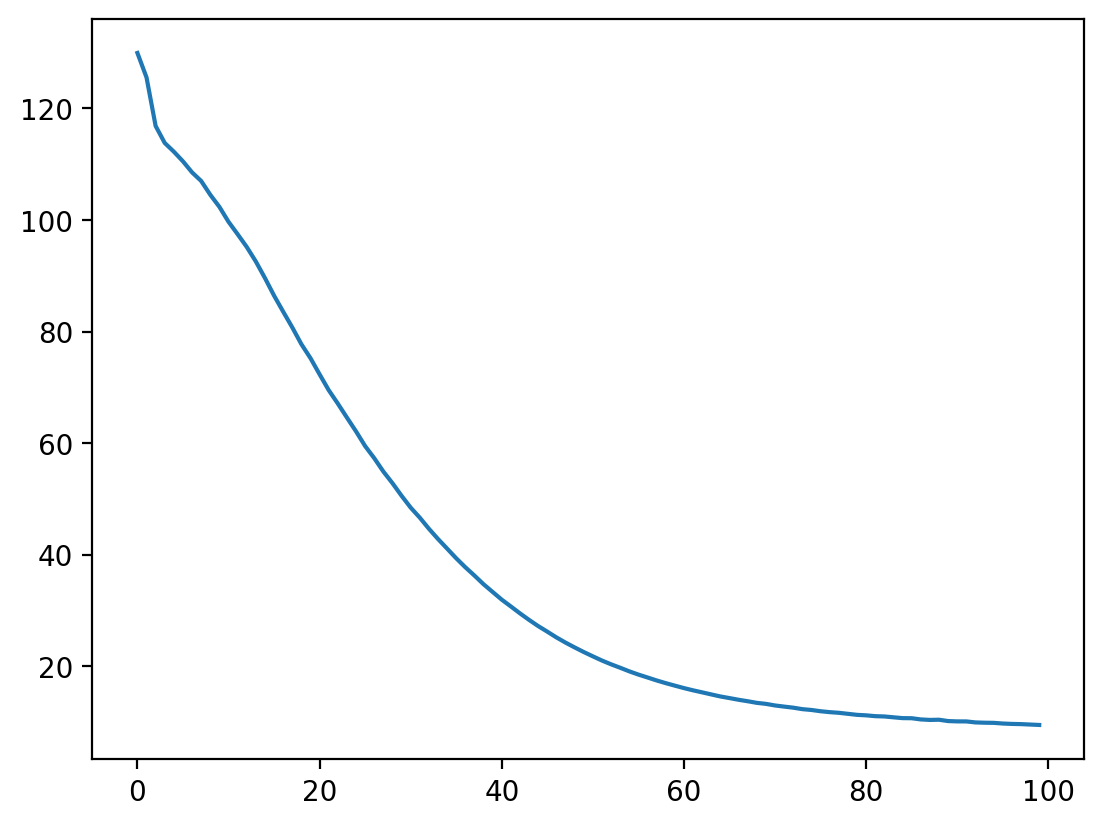

In [23]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch 100: {history.history['loss'][99]}")
plt.plot(history.history['loss'])

In [24]:
import pandas as pd

In [25]:
pd.DataFrame(history.history)

,loss,dense_loss,dense_1_loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_6_loss,dense_7_loss,dense_8_loss,...,dense_20_accuracy,dense_21_accuracy,dense_22_accuracy,dense_23_accuracy,dense_24_accuracy,dense_25_accuracy,dense_26_accuracy,dense_27_accuracy,dense_28_accuracy,dense_29_accuracy
0,129.944427,4.495483,4.489370,4.490925,4.490810,4.486557,4.481211,4.483621,4.479268,4.478994,...,0.133333,0.066667,0.083333,0.066667,0.116667,0.066667,0.050000,0.066667,0.066667,0.016667
1,125.557129,4.478398,4.438039,4.435781,4.417668,4.400611,4.383012,4.354464,4.346821,4.333727,...,0.150000,0.100000,0.050000,0.100000,0.100000,0.116667,0.083333,0.133333,0.150000,0.000000
2,116.850311,4.457081,4.374598,4.365164,4.301238,4.282723,4.169767,4.077359,3.965349,3.963985,...,0.100000,0.066667,0.066667,0.066667,0.050000,0.066667,0.033333,0.133333,0.066667,0.000000
3,113.805504,4.437925,4.310536,4.271606,4.160970,4.086194,3.905872,3.711638,3.713434,3.769590,...,0.100000,0.150000,0.066667,0.066667,0.066667,0.100000,0.066667,0.166667,0.150000,0.000000
4,112.244492,4.423744,4.250974,4.191424,4.053414,3.978656,3.784298,3.668307,3.757616,3.772354,...,0.100000,0.150000,0.066667,0.066667,0.066667,0.100000,0.066667,0.166667,0.150000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.725845,4.010383,1.508609,0.536283,0.253584,0.177714,0.160822,0.144485,0.147626,0.122876,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.983333,0.000000
96,9.656081,4.008875,1.499095,0.526825,0.248905,0.175702,0.156481,0.142276,0.145023,0.121918,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
97,9.619933,4.007206,1.489939,0.519683,0.244840,0.172160,0.153871,0.142029,0.143186,0.119330,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
98,9.543577,4.005624,1.480402,0.510453,0.240715,0.166744,0.150269,0.136555,0.140354,0.118088,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.983333,0.033333


In [44]:
def music_inference_model(LSTM_cell, densor, Ty=100):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Get the shape of input values
    n_values = densor.units
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    ### START CODE HERE ###
    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        # Step 2.A: Perform one step of LSTM_cell. Use "x", not "x0" (≈1 line)
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        out = densor(a)
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, 90) (≈1 line)
        outputs.append(out)

        
        # Step 2.D: 
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        # See instructions above.
        x = tf.math.argmax(out, axis=-1)
        x = tf.one_hot(x, n_values)
        # Step 2.E: 
        # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, 90)
        x = RepeatVector(1)(x)
        
    # Step 3: Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model = Model(inputs=[x0, a0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return inference_model

In [45]:
inference_model = music_inference_model(LSTM_cell, densor, Ty = 50)

In [47]:
# Check the inference model
#inference_model.summary()

In [48]:
n_values

90

In [35]:
x_initializer = np.zeros((1, 1, n_values))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [49]:
def predict_and_sample(inference_model, x_initializer = x_initializer, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, 90), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, 90), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    n_values = x_initializer.shape[2]
    
    ### START CODE HERE ###
    # Step 1: Use your inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
    # Step 2: Convert "pred" into an np.array() of indices with the maximum probabilities
    indices = np.argmax(pred, axis = -1)
    # Step 3: Convert indices to one-hot vectors, the shape of the results should be (Ty, n_values)
    results = to_categorical(indices, num_classes=n_values)
    ### END CODE HERE ###
    
    return results, indices

In [50]:
results, indices = predict_and_sample(inference_model, x_initializer, a_initializer, c_initializer)

print("np.argmax(results[12]) =", np.argmax(results[12]))
print("np.argmax(results[17]) =", np.argmax(results[17]))
print("list(indices[12:18]) =", list(indices[12:18]))

1/1 [==============================] - 34s 34s/step
np.argmax(results[12]) = 0
np.argmax(results[17]) = 66
list(indices[12:18]) = [array([0], dtype=int64), array([14], dtype=int64), array([23], dtype=int64), array([46], dtype=int64), array([83], dtype=int64), array([66], dtype=int64)]


In [56]:
def generate_music(inference_model, indices_tones, chords, diversity = 0.5):
    """
    Generates music using a model trained to learn musical patterns of a jazz soloist. Creates an audio stream
    to save the music and play it.
    
    Arguments:
    model -- Keras model Instance, output of djmodel()
    indices_tones -- a python dictionary mapping indices (0-77) into their corresponding unique tone (ex: A,0.250,< m2,P-4 >)
    temperature -- scalar value, defines how conservative/creative the model is when generating music
    
    Returns:
    predicted_tones -- python list containing predicted tones
    """
    
    # set up audio stream
    out_stream = stream.Stream()
    
    # Initialize chord variables
    curr_offset = 0.0                                     # variable used to write sounds to the Stream.
    num_chords = int(len(chords) / 3)                     # number of different set of chords
    
    print("Predicting new values for different set of chords.")
    # Loop over all 18 set of chords. At each iteration generate a sequence of tones
    # and use the current chords to convert it into actual sounds 
    for i in range(1, num_chords):
        
        # Retrieve current chord from stream
        curr_chords = stream.Voice()
        
        # Loop over the chords of the current set of chords
        for j in chords[i]:
            # Add chord to the current chords with the adequate offset, no need to understand this
            curr_chords.insert((j.offset % 4), j)
        
        # Generate a sequence of tones using the model
        _, indices = predict_and_sample(inference_model)
        indices = list(indices.squeeze())
        pred = [indices_tones[p] for p in indices]
        
        predicted_tones = 'C,0.25 '
        for k in range(len(pred) - 1):
            predicted_tones += pred[k] + ' ' 
        
        predicted_tones +=  pred[-1]
                
        #### POST PROCESSING OF THE PREDICTED TONES ####
        # We will consider "A" and "X" as "C" tones. It is a common choice.
        predicted_tones = predicted_tones.replace(' A',' C').replace(' X',' C')

        # Pruning #1: smoothing measure
        predicted_tones = prune_grammar(predicted_tones)
        
        # Use predicted tones and current chords to generate sounds
        sounds = unparse_grammar(predicted_tones, curr_chords)

        # Pruning #2: removing repeated and too close together sounds
        sounds = prune_notes(sounds)

        # Quality assurance: clean up sounds
        sounds = clean_up_notes(sounds)

        # Print number of tones/notes in sounds
        print('Generated %s sounds using the predicted values for the set of chords ("%s") and after pruning' % (len([k for k in sounds if isinstance(k, note.Note)]), i))
        
        # Insert sounds into the output stream
        for m in sounds:
            out_stream.insert(curr_offset + m.offset, m)
        for mc in curr_chords:
            out_stream.insert(curr_offset + mc.offset, mc)

        curr_offset += 4.0
        
    # Initialize tempo of the output stream with 130 bit per minute
    out_stream.insert(0.0, tempo.MetronomeMark(number=130))

    # Save audio stream to file
    mf = midi.translate.streamToMidiFile(out_stream)
    mf.open("my_music.midi", 'wb')
    mf.write()
    print("Your generated music is saved in my_music.midi")
    mf.close()
    
    # Play the final stream through output (see 'play' lambda function above)
    # play = lambda x: midi.realtime.StreamPlayer(x).play()
    # play(out_stream)
    
    return out_stream


def predict_and_sample(inference_model, x_initializer = x_initializer, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, 78), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    Ty -- length of the sequence you'd like to generate.
    
    Returns:
    results -- numpy-array of shape (Ty, 78), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    ### START CODE HERE ###
    pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
    indices = np.argmax(pred, axis = -1)
    results = to_categorical(indices, num_classes=90)
    ### END CODE HERE ###
    
    return results, indices


def note_to_freq(note, concert_A=440.0):
  '''
  from wikipedia: http://en.wikipedia.org/wiki/MIDI_Tuning_Standard#Frequency_values
  '''
  return (2.0 ** ((note - 69) / 12.0)) * concert_A

def ticks_to_ms(ticks, tempo, mid):
    tick_ms = math.ceil((60000.0 / tempo) / mid.ticks_per_beat)
    return ticks * tick_ms

def mid2wav(file):
    mid = MidiFile(file)
    output = AudioSegment.silent(mid.length * 1000.0)

    tempo = 130 # bpm

    for track in mid.tracks:
        # position of rendering in ms
        current_pos = 0.0
        current_notes = defaultdict(dict)

        for msg in track:
            current_pos += ticks_to_ms(msg.time, tempo, mid)
            if msg.type == 'note_on':
                if msg.note in current_notes[msg.channel]:
                    current_notes[msg.channel][msg.note].append((current_pos, msg))
                else:
                    current_notes[msg.channel][msg.note] = [(current_pos, msg)]


            if msg.type == 'note_off':
                start_pos, start_msg = current_notes[msg.channel][msg.note].pop()

                duration = math.ceil(current_pos - start_pos)
                signal_generator = Sine(note_to_freq(msg.note, 500))
                #print(duration)
                rendered = signal_generator.to_audio_segment(duration=duration-50, volume=-20).fade_out(100).fade_in(30)

                output = output.overlay(rendered, start_pos)

    output.export("rendered.wav", format="wav")

In [52]:
# from qa.py
#----------------------------HELPER FUNCTIONS----------------------------------#

''' Helper function to down num to the nearest multiple of mult. '''
def __roundDown(num, mult):
    return (float(num) - (float(num) % mult))

''' Helper function to round up num to nearest multiple of mult. '''
def __roundUp(num, mult):
    return __roundDown(num, mult) + mult

''' Helper function that, based on if upDown < 0 or upDown >= 0, rounds number 
    down or up respectively to nearest multiple of mult. '''
def __roundUpDown(num, mult, upDown):
    if upDown < 0:
        return __roundDown(num, mult)
    else:
        return __roundUp(num, mult)

''' Helper function, from recipes, to iterate over list in chunks of n 
    length. '''
def __grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

#----------------------------PUBLIC FUNCTIONS----------------------------------#

''' Smooth the measure, ensuring that everything is in standard note lengths 
    (e.g., 0.125, 0.250, 0.333 ... ). '''
def prune_grammar(curr_grammar):
    pruned_grammar = curr_grammar.split(' ')

    for ix, gram in enumerate(pruned_grammar):
        terms = gram.split(',')
        terms[1] = str(__roundUpDown(float(terms[1]), 0.250, 
            random.choice([-1, 1])))
        pruned_grammar[ix] = ','.join(terms)
    pruned_grammar = ' '.join(pruned_grammar)

    return pruned_grammar

''' Remove repeated notes, and notes that are too close together. '''
def prune_notes(curr_notes):
    for n1, n2 in __grouper(curr_notes, n=2):
        if n2 == None: # corner case: odd-length list
            continue
        if isinstance(n1, note.Note) and isinstance(n2, note.Note):
            if n1.nameWithOctave == n2.nameWithOctave:
                curr_notes.remove(n2)

    return curr_notes

''' Perform quality assurance on notes '''
def clean_up_notes(curr_notes):
    removeIxs = []
    for ix, m in enumerate(curr_notes):
        # QA1: ensure nothing is of 0 quarter note len, if so changes its len
        if (m.quarterLength == 0.0):
            m.quarterLength = 0.250
        # QA2: ensure no two melody notes have same offset, i.e. form a chord.
        # Sorted, so same offset would be consecutive notes.
        if (ix < (len(curr_notes) - 1)):
            if (m.offset == curr_notes[ix + 1].offset and
                isinstance(curr_notes[ix + 1], note.Note)):
                removeIxs.append((ix + 1))
    curr_notes = [i for ix, i in enumerate(curr_notes) if ix not in removeIxs]

    return curr_notes

In [54]:
import random

In [57]:
out_stream = generate_music(inference_model, indices_values, chords)

Predicting new values for different set of chords.
1/1 [==============================] - 0s 71ms/step
Generated 40 sounds using the predicted values for the set of chords ("1") and after pruning
1/1 [==============================] - 0s 31ms/step
Generated 40 sounds using the predicted values for the set of chords ("2") and after pruning
1/1 [==============================] - 0s 47ms/step
Generated 40 sounds using the predicted values for the set of chords ("3") and after pruning
1/1 [==============================] - 0s 47ms/step
Generated 40 sounds using the predicted values for the set of chords ("4") and after pruning
1/1 [==============================] - 0s 50ms/step
Generated 40 sounds using the predicted values for the set of chords ("5") and after pruning
Your generated music is saved in my_music.midi


In [14]:
IPython.display.Audio('my_music.mp3')